In [1]:
# pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

In [2]:
import os
import time
import uuid
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
import json
import numpy as np
import albumentations as alb

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [11]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [4]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [5]:
images.as_numpy_iterator().next()

b'data\\images\\2f4a5870-a3e7-11ed-b2bc-48ba4e89b37b.jpg'

In [6]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [7]:
images = images.map(load_image)

In [8]:
images.as_numpy_iterator().next()

array([[[132, 135, 108],
        [132, 134, 110],
        [132, 134, 112],
        ...,
        [191, 190, 206],
        [193, 190, 207],
        [194, 191, 208]],

       [[130, 134, 109],
        [130, 134, 111],
        [130, 133, 112],
        ...,
        [189, 188, 202],
        [191, 189, 203],
        [191, 189, 203]],

       [[130, 135, 115],
        [130, 135, 115],
        [130, 134, 117],
        ...,
        [189, 189, 201],
        [189, 189, 201],
        [189, 189, 201]],

       ...,

       [[154, 107,  63],
        [153, 106,  60],
        [152, 108,  63],
        ...,
        [121, 129, 106],
        [119, 129, 105],
        [117, 130, 104]],

       [[150, 106,  59],
        [149, 105,  56],
        [150, 106,  59],
        ...,
        [123, 129, 103],
        [119, 130, 100],
        [117, 131,  98]],

       [[149, 105,  56],
        [148, 104,  55],
        [149, 105,  56],
        ...,
        [122, 129,  98],
        [119, 130,  98],
        [117, 131,  96]]

In [9]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [10]:
image_generator = images.batch(4).as_numpy_iterator()

In [11]:
plot_images = image_generator.next()

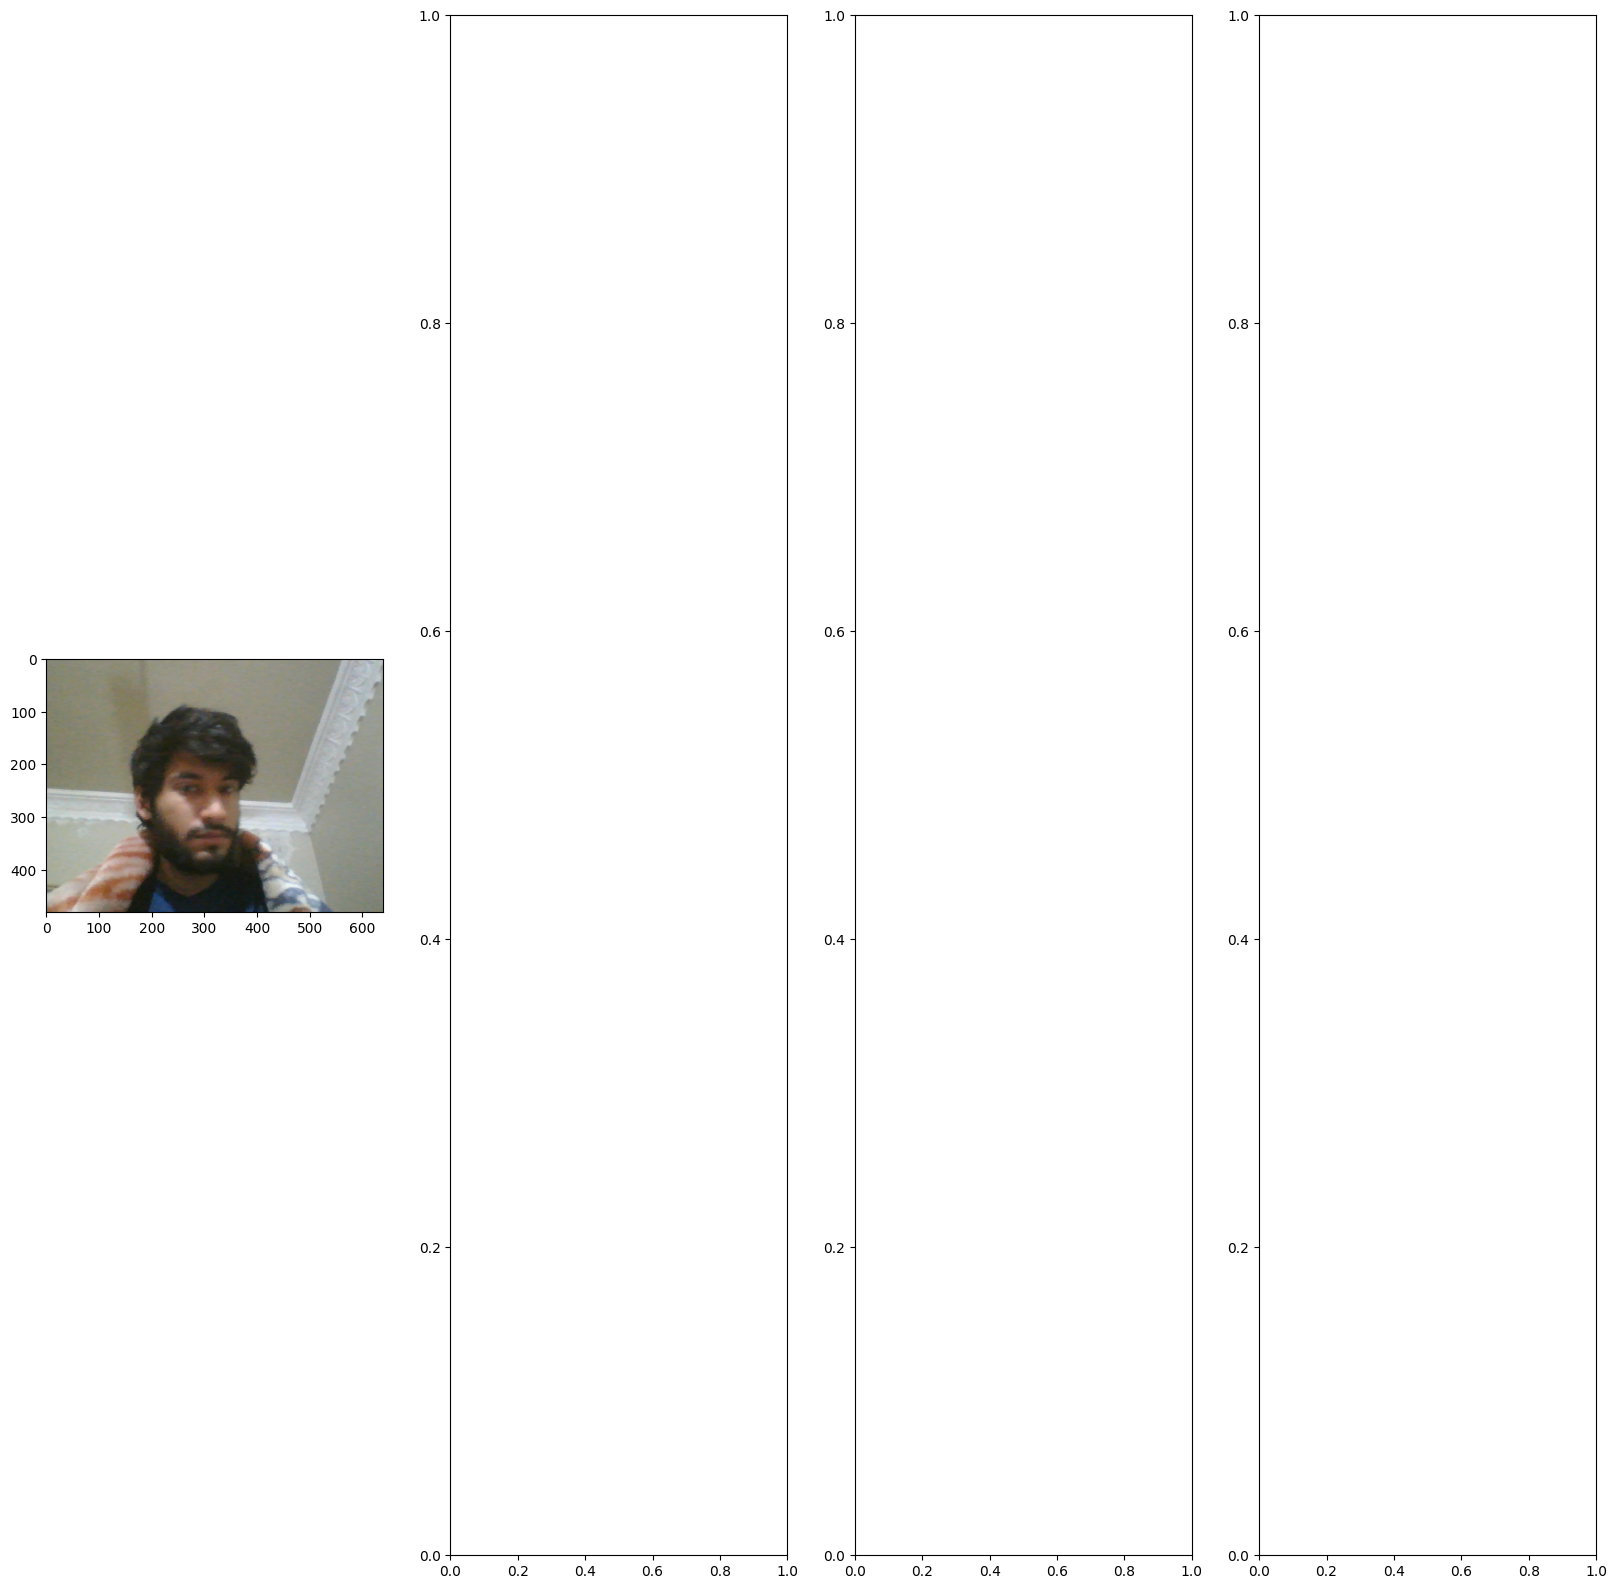

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [13]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)     

In [14]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [15]:
img = cv2.imread(os.path.join('data','train', 'images','2ef7f7c4-a3e7-11ed-bf4c-48ba4e89b37b.jpg'))

In [16]:
with open(os.path.join('data', 'train', 'labels', '2ef7f7c4-a3e7-11ed-bf4c-48ba4e89b37b.json'), 'r') as f:
    label = json.load(f)

In [17]:
label['shapes'][0]['points']

[[175.3639846743295, 92.68199233716474],
 [414.0613026819923, 427.16475095785444]]

In [18]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [19]:
coords

[175.3639846743295, 92.68199233716474, 414.0613026819923, 427.16475095785444]

In [20]:
coords = list(np.divide(coords, [640,480,640,480]))

In [21]:
coords

[0.27400622605363983,
 0.19308748403575987,
 0.6469707854406129,
 0.8899265644955301]

In [22]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [23]:
augmented['bboxes'][0][2:]

(0.549025117071094, 0.9403661132396766)

In [24]:
augmented['bboxes']

[(0.01858663260962108,
  0.19707109408258833,
  0.549025117071094,
  0.9403661132396766)]

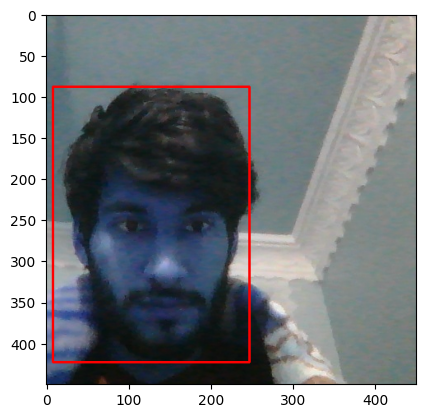

In [25]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [51]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'Images')):
        img = cv2.imread(os.path.join('data', partition, 'Images', image))
        
        # print(os.path.join('data', partition, 'Images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))
            # print(coords)
            
            
            

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                
                # xs = os.path.join('aug_data', partition, 'Images', f'{image.split(".")[0]}.{x}.jpg')
                # print(xs)
                cv2.imwrite(os.path.join('\\aug_data', partition, 'Images', f'{image.split(".")[0]}-{x}.jpg'), augmented['image'])
                

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    # print("True")
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                xname = os.path.join('data/aug_data', partition, 'labels', f'{image.split(".")[0]}-{x}.json')
                print(xname)
                with open(xname, "w") as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

data/aug_data\train\labels\2e49e185-a3e7-11ed-94d2-48ba4e89b37b-0.json
data/aug_data\train\labels\2e49e185-a3e7-11ed-94d2-48ba4e89b37b-1.json
data/aug_data\train\labels\2e49e185-a3e7-11ed-94d2-48ba4e89b37b-2.json
data/aug_data\train\labels\2e49e185-a3e7-11ed-94d2-48ba4e89b37b-3.json
data/aug_data\train\labels\2e49e185-a3e7-11ed-94d2-48ba4e89b37b-4.json
data/aug_data\train\labels\2e49e185-a3e7-11ed-94d2-48ba4e89b37b-5.json
data/aug_data\train\labels\2e49e185-a3e7-11ed-94d2-48ba4e89b37b-6.json
data/aug_data\train\labels\2e49e185-a3e7-11ed-94d2-48ba4e89b37b-7.json
data/aug_data\train\labels\2e49e185-a3e7-11ed-94d2-48ba4e89b37b-8.json
data/aug_data\train\labels\2e49e185-a3e7-11ed-94d2-48ba4e89b37b-9.json
data/aug_data\train\labels\2e49e185-a3e7-11ed-94d2-48ba4e89b37b-10.json
data/aug_data\train\labels\2e49e185-a3e7-11ed-94d2-48ba4e89b37b-11.json
data/aug_data\train\labels\2e49e185-a3e7-11ed-94d2-48ba4e89b37b-12.json
data/aug_data\train\labels\2e49e185-a3e7-11ed-94d2-48ba4e89b37b-13.json
da